### Network as is known have many parameters. But are they all so important?

Go and check it!

### 1. Try to zeroing of near-zero weights($10e2$)
Train some model and save weights from it.
After it, gradually zeroing weights and see how the quality is changing.

In [1]:
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqn
%matplotlib inline

from simple_model import ConvModel
from dataset.opensets import MNIST
from dataset import F, V, B

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

### About model:
* 2 convolution layers:
    * first layer: 
        kernel = 7x7x1, num_filters = 16 => 784 weights
    * second layer:
         kernel = 5x5x16, num_filters = 32 => 12800 weights
* 2 dense layers:
    * first layer: num_filters = 256, num_inputs = 128 => 32768 weights
    * second layer: num_filters = 10, num_inputs = 256 => 2560 weights
    
### Number of weights: 48912

In sell below you can see new element of batch class - MNIST. It's a class inside which the MNIST is loaded.
Code of MNIST you can see [here](https://github.com/analysiscenter/dataset/blob/master/dataset/opensets/mnist.py).

In [3]:
mnist = MNIST()

ExtractingExtracting  /tmp/train-images-idx3-ubyte.gzExtracting
 /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz



As always we create pipeline, but in this time you can see new line in pipeline - is import_model. Because we use [dymanic](https://github.com/analysiscenter/dataset/blob/master/doc/models.md) model. Our model created ewerytime, when we create new pipeline, thereforse when we create test pipeline, we create new model. And in order to load the results of learning the inference pipeline, we use import_model.

In [4]:
inputs_config = dict(images={'shape': (28, 28, 1)},
                     labels={'classes': (10), 'transform': 'ohe', 'name': 'targets'})

In [5]:
train_pipeline = (mnist.train
                 .p
                 .init_variable('loss', init_on_each_run=list)
                 .init_model('dynamic',
                            ConvModel,
                            'conv',
                            config={'inputs': inputs_config,
                                    'loss': 'softmax_cross_entropy',
                                    'optimizer': 'Adam',
                                    'input_block/inputs': 'images',
                                    'head/units': [256, 10],
                                    'output': dict(ops=['labels', 'accuracy'])})
                 .train_model('conv',
                             feed_dict={'images': B('images'),
                                        'labels': B('labels')}))
test_pipeline = (mnist.test
                .p
                .import_model('conv', train_pipeline)
                .init_variable('predict', init_on_each_run=list)
                .predict_model('conv', 
                               fetches='ConvModel/accuracy',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('predict'), mode='a'))

In [6]:
MAX_ITER = 600
for curr_iter in tqn(range(1, MAX_ITER + 1)):
    train_pipeline.next_batch(100, n_epochs=None, shuffle=True)
    test_pipeline.next_batch(100, n_epochs=None, shuffle=True)

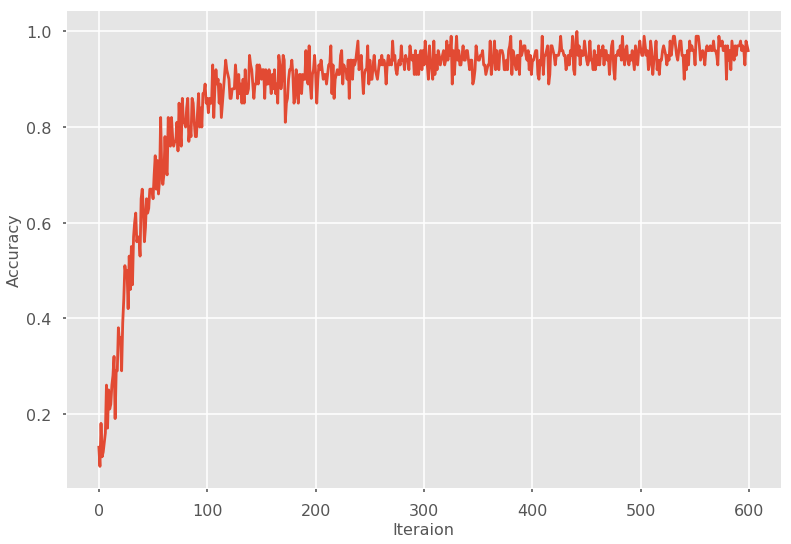

In [7]:
plt.xlabel('Iteraion', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
acc = test_pipeline.get_variable('predict')
plt.plot(acc)

Using "get_model_by_name" we can return output of the model. In our case we return tensorflow session for getting weights from the model.

In [8]:
sess = train_pipeline.get_model_by_name('conv').session
graph = sess.graph

After it, let's zero weights by slowly moving the threshold from 1e-2 to 9e-2 and see how this affects the quality

In [9]:
weights, biases = [], []
variables = graph.get_collection('trainable_variables')
weights.append(sess.run(variables[::2]))
biases.append(sess.run(variables[1::2]))

weights = np.array(weights[0])
biases = np.array(biases[0])
weights_global = copy.deepcopy(weights)
biases_global = copy.deepcopy(biases)
percentage = []
accuracy = []
for const in tqn(np.linspace(1e-2, 9e-2)):
    zeros_on_layer = []
    for i in range(len(weights)):
        weight_ind = np.where(np.abs(weights[i]) < const)
        zeros_on_layer.append(len(weight_ind[0]) / np.array(weights[i].shape).prod())
        weights[i][weight_ind] = 0
        biases[i][np.where(np.abs(biases[i]) < const)] = 0
    percentage.append(zeros_on_layer)
    
    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)
    test_pipeline.next_batch(100, shuffle=True)
    accuracy.append(acc[-1])

In [10]:
a = np.linspace(1e-2,9e-2)

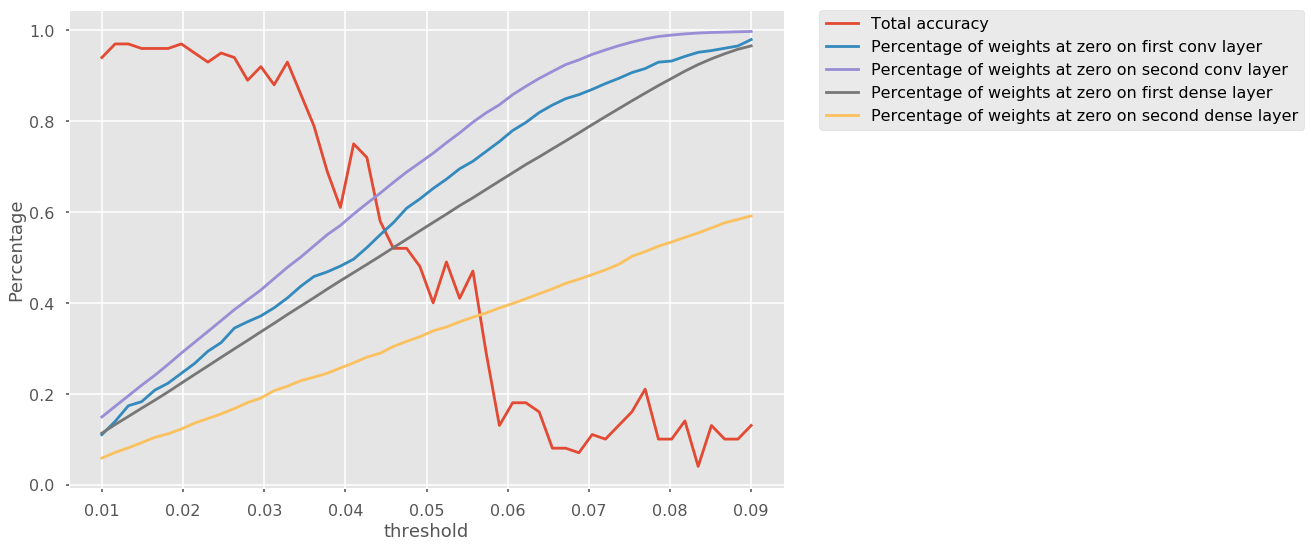

In [11]:
plt.xlabel('threshold', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.plot(a, accuracy, label='Total accuracy')
plt.plot( a,np.array(percentage)[:,0], label='Percentage of weights at zero on first conv layer')
plt.plot( a,np.array(percentage)[:,1], label='Percentage of weights at zero on second conv layer')
plt.plot( a,np.array(percentage)[:,2], label='Percentage of weights at zero on first dense layer')
plt.plot( a,np.array(percentage)[:,3], label='Percentage of weights at zero on second dense layer')
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Interesting, that we can zero ~ 30% weights without decrease quality.

### 2. Replace weights on each layer to clusters. 
If quality doesn't change, this method can allow to store weights more optimally.

As last time save initial values.

In [12]:
weights = copy.deepcopy(weights_global)
biases = copy.deepcopy(biases_global)

In [13]:
def clear():
    """ Function to load initial values """
    weights = copy.deepcopy(weights_global)
    biases = copy.deepcopy(biases_global)
    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)

We will reduce the number of clusters. For each layer, the initial number of clusters is different, as you can see in the "clusters" variable.

In [14]:
weights = copy.deepcopy(weights_global)
biases = copy.deepcopy(biases_global)

accuracy = []
save = []
clasters = np.hstack((np.linspace(30, 4, 15, dtype=np.int32), \
                      np.linspace(100, 4, 15, dtype=np.int32), \
                      np.linspace(500, 4, 15, dtype=np.int32), \
                      np.linspace(50, 4, 15, dtype=np.int32))).reshape(4,-1).T

uniq = (sum([len(np.unique(i)) for i in weights]) + sum([len(np.unique(i)) for i in biases]))

for claster in tqn(zip(clasters,np.array([2, 2, 2, 2]*15).reshape(15, 4))):
    
    weights_clust, bias_clust = claster
    save_layers = []
    for i in range(4):
        kmeans = KMeans(weights_clust[i]).fit(weights[i].reshape(-1, 1).astype(np.float64))
        shape = weights[i].shape 
        weights[i] = kmeans.cluster_centers_[kmeans.predict(weights[i].reshape(-1, 1))].reshape(shape)
        kmeans = KMeans(bias_clust[i]).fit(biases[i].reshape(-1, 1))
        shape = biases[i].shape
        biases[i] = kmeans.cluster_centers_[kmeans.predict(biases[i].reshape(-1, 1))].reshape(shape)

    save.append((sum(weights_clust) + sum(bias_clust)) / uniq)

    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)
    test_pipeline.next_batch(100)
    accuracy.append(acc[-1])
    clear()

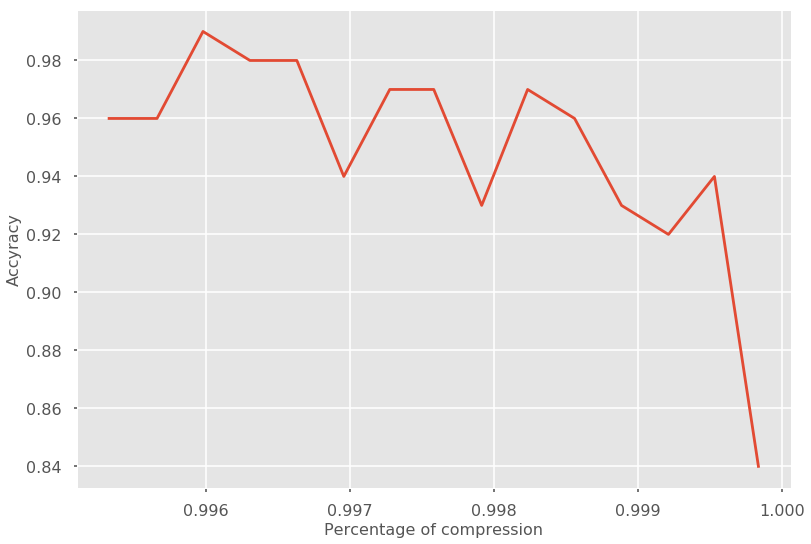

In [15]:
percent_save = 1 - np.array(save)
plt.xlabel('Percentage of compression', fontsize=16)
plt.ylabel('Accyracy', fontsize=16)
plt.plot(percent_save, accuracy)

As you can see, we can reduce the number of different values by more than 99% without loss of quality. In [this](https://arxiv.org/abs/1510.00149) paper you can find how we can reduce ResNet more than 50 times.